In [ ]:
# import gymnasium as gym
# from gymnasium import spaces
# import numpy as np
# import random

# class RoutingEnv(gym.Env):
#     metadata = {"render_modes": ["human"], "render_fps": 4}

#     def __init__(self, num_machines=3, num_query_types=5):
#         super(RoutingEnv, self).__init__()

#         self.num_machines = num_machines
#         self.num_query_types = num_query_types

#         # Observation space: [CPU utilization per machine] + [query type counts per machine]
#         self.observation_space = spaces.Box(
#             low=0,
#             high=1,
#             shape=(self.num_machines * (1 + self.num_query_types),),
#             dtype=np.float32,
#         )

#         # Action space: pick one machine to send the query to
#         self.action_space = spaces.Discrete(self.num_machines)

#         self.cpu_util = np.zeros(self.num_machines)
#         self.query_counts = np.zeros((self.num_machines, self.num_query_types))
#         self.current_query = None

#     def reset(self, seed=None, options=None):
#         super().reset(seed=seed)
#         self.cpu_util = np.random.uniform(0.1, 0.3, size=self.num_machines)
#         self.query_counts = np.zeros((self.num_machines, self.num_query_types))
#         self.current_query = self._generate_query()
#         observation = self._get_obs()
#         info = {}
#         return observation, info

#     def _generate_query(self):
#         return random.randint(0, self.num_query_types - 1)

#     def _get_obs(self):
#         obs = []
#         for i in range(self.num_machines):
#             obs.append(self.cpu_util[i])
#             obs.extend(self.query_counts[i])
#         return np.array(obs, dtype=np.float32)

#     def step(self, action):
#         query_type = self.current_query

#         # Update CPU and query count
#         self.query_counts[action][query_type] += 1
#         self.cpu_util[action] += random.uniform(0.01, 0.05)

#         # Compute reward (negative latency)
#         latency = 0.1 + self.cpu_util[action] + (0.02 * self.query_counts[action][query_type])
#         reward = -latency

#         self.cpu_util = np.clip(self.cpu_util, 0.0, 1.0)

#         self.current_query = self._generate_query()
#         observation = self._get_obs()
#         terminated = False
#         truncated = False
#         info = {}

#         return observation, reward, terminated, truncated, info

#     def render(self):
#         print(f"CPU: {self.cpu_util}")
#         print(f"Query Counts: {self.query_counts}")

#     def close(self):
#         pass

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

class RoutingEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, num_machines=3):
        super(RoutingEnv, self).__init__()

        self.num_machines = num_machines
        self.query_types = ["SELECT", "JOIN"]
        self.query_cost = {"SELECT": 1, "JOIN": 10}  # JOIN is 10x heavier

        self.query_type_map = {name: i for i, name in enumerate(self.query_types)}
        self.num_query_types = len(self.query_types)

        # Observation: CPU util + pending queries per type for each machine
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(self.num_machines * (1 + self.num_query_types),),
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(self.num_machines)

        self.cpu_util = np.zeros(self.num_machines)
        self.query_load = np.zeros((self.num_machines, self.num_query_types))  # time remaining for queries

        # Machine-specific recovery rates (lower means slower cooldown)
        self.cpu_recovery_rates = np.random.uniform(0.01, 0.05, size=self.num_machines)

        self.current_query = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.cpu_util = np.random.uniform(0.1, 0.3, size=self.num_machines)
        self.query_load = np.zeros((self.num_machines, self.num_query_types))
        self.cpu_recovery_rates = np.random.uniform(0.01, 0.05, size=self.num_machines)
        self.current_query = self._generate_query()
        return self._get_obs(), {}

    def _generate_query(self):
        return random.choice(self.query_types)

    def _get_obs(self):
        obs = []
        for i in range(self.num_machines):
            obs.append(self.cpu_util[i])
            obs.extend(self.query_load[i])
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        query_type = self.current_query
        qtype_idx = self.query_type_map[query_type]
        cost = self.query_cost[query_type]

        # Add query to chosen machine
        self.query_load[action][qtype_idx] += cost
        self.cpu_util[action] += cost * 0.01  # CPU cost per time unit

        # Simulate query processing + CPU recovery
        for i in range(self.num_machines):
            self.query_load[i] = np.maximum(self.query_load[i] - 1, 0)  # reduce load per step
            self.cpu_util[i] = max(self.cpu_util[i] - self.cpu_recovery_rates[i], 0)

        # Compute reward: lower total CPU utilization = better
        reward = -np.mean(self.cpu_util)

        # Update current query
        self.current_query = self._generate_query()
        obs = self._get_obs()
        terminated = False
        truncated = False
        info = {}

        return obs, reward, terminated, truncated, info

    def render(self):
        print("\n--- ENV STATE ---")
        for i in range(self.num_machines):
            print(
                f"Machine {i}: CPU={self.cpu_util[i]:.2f}, "
                f"SELECT={self.query_load[i][0]:.0f}, JOIN={self.query_load[i][1]:.0f}, "
                f"Recovery Rate={self.cpu_recovery_rates[i]:.3f}"
            )

    def close(self):
        pass

In [ ]:
# from stable_baselines3 import PPO
# from stable_baselines3.common.env_checker import check_env
# # from routing_env import RoutingEnv  # make sure your class is saved in routing_env.py

# # Create the environment
# env = RoutingEnv(num_machines=3, num_query_types=5)

# # Optional: Check that the environment follows Gym's API
# check_env(env, warn=True)

# # Wrap the environment with a dummy VecEnv (Stable-Baselines3 needs this)
# from stable_baselines3.common.env_util import make_vec_env
# vec_env = make_vec_env(lambda: RoutingEnv(), n_envs=1)

# # Create the PPO model
# model = PPO("MlpPolicy", vec_env, verbose=1)

# # Train the model
# model.learn(total_timesteps=10000)

# # Save the model
# model.save("ppo-routing-agent")

# # Test the trained model
# obs, _ = env.reset()
# for _ in range(20):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, terminated, truncated, _ = env.step(action)
#     env.render()
#     if terminated or truncated:
#         obs, _ = env.reset()

TypeError: RoutingEnv.__init__() got an unexpected keyword argument 'num_query_types'

Episode 0, Total reward: -5.21
Episode 10, Total reward: -10.85
Episode 20, Total reward: -9.85
Episode 30, Total reward: -13.77
Episode 40, Total reward: -14.32
Episode 50, Total reward: -23.55
Episode 60, Total reward: -37.25
Episode 70, Total reward: -5.70
Episode 80, Total reward: -25.25
Episode 90, Total reward: -2.67
Episode 100, Total reward: -5.41
Episode 110, Total reward: -14.91
Episode 120, Total reward: -9.99
Episode 130, Total reward: -3.84
Episode 140, Total reward: -4.58
Episode 150, Total reward: -9.05
Episode 160, Total reward: -35.50
Episode 170, Total reward: -10.45
Episode 180, Total reward: -17.03
Episode 190, Total reward: -21.57
Episode 200, Total reward: -18.26
Episode 210, Total reward: -16.30
Episode 220, Total reward: -11.34
Episode 230, Total reward: -9.79
Episode 240, Total reward: -5.63
Episode 250, Total reward: -2.58
Episode 260, Total reward: -12.61
Episode 270, Total reward: -5.60
Episode 280, Total reward: -8.42
Episode 290, Total reward: -3.66
Episod

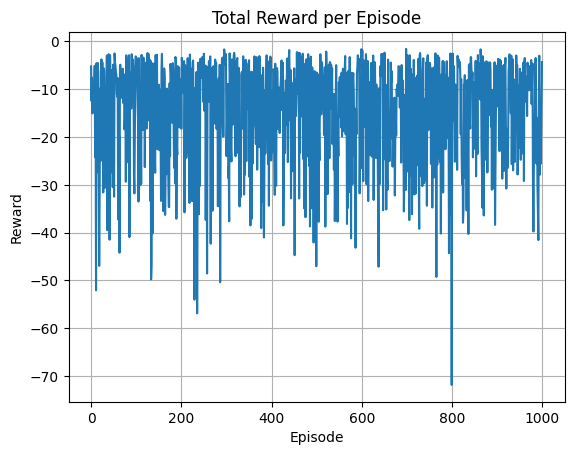

In [7]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
# from routing_env import RoutingEnv

# Create and wrap the environment
env = RoutingEnv()
vec_env = make_vec_env(lambda: RoutingEnv(), n_envs=1)

# Create the model
model = PPO("MlpPolicy", vec_env, verbose=0)

# Track rewards manually
reward_log = []
num_episodes = 1000
episode_length = 100

for ep in range(num_episodes):
    obs, _ = env.reset()
    total_reward = 0

    for _ in range(episode_length):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated:
            break

    reward_log.append(total_reward)

    # Train model after each episode
    model.learn(total_timesteps=episode_length, reset_num_timesteps=False, progress_bar=False)

    if ep % 10 == 0:
        print(f"Episode {ep}, Total reward: {total_reward:.2f}")

# Save model
model.save("ppo-routing-agent")

# Plot reward trend
plt.plot(reward_log)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

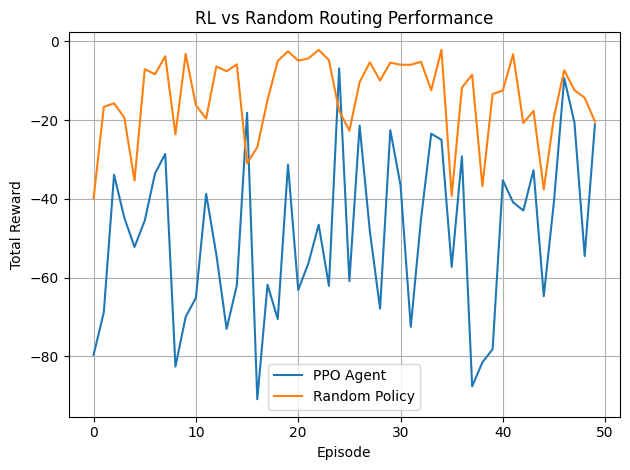

Average PPO Reward: -49.22
Average Random Reward: -14.06


In [8]:
import numpy as np
import matplotlib.pyplot as plt
# from routing_env import RoutingEnv
from stable_baselines3 import PPO

def evaluate_policy(env, model=None, policy_name="RL", episodes=50, episode_length=100):
    rewards = []

    for ep in range(episodes):
        obs, _ = env.reset()
        total_reward = 0

        for _ in range(episode_length):
            if policy_name == "random":
                action = env.action_space.sample()
            else:
                action, _ = model.predict(obs, deterministic=True)

            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        rewards.append(total_reward)
    
    return rewards

# Load trained PPO model
model = PPO.load("ppo-routing-agent")

# Create two fresh environments for fair testing
env_rl = RoutingEnv()
env_random = RoutingEnv()

# Evaluate both policies
ppo_rewards = evaluate_policy(env_rl, model=model, policy_name="RL")
random_rewards = evaluate_policy(env_random, model=None, policy_name="random")

# Plot comparison
plt.plot(ppo_rewards, label="PPO Agent")
plt.plot(random_rewards, label="Random Policy")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("RL vs Random Routing Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print average performance
print(f"Average PPO Reward: {np.mean(ppo_rewards):.2f}")
print(f"Average Random Reward: {np.mean(random_rewards):.2f}")